# BRDF Validation

Compares BRDF calculations in sasktran1 to the equivalent calculation in sasktran2.

NOTE: At the time of comparison SASKTRAN1 uses an azimuth angle that is off by 180 degrees when evaluating the BRDF
to perform accurarate comparisons we basically just disable rayleigh scattering and adjust the azimuth angle

In [1]:
import sasktran2 as sk
import numpy as np
import sasktran as sk1
import matplotlib.pyplot as plt


COS_VIEWING_ZENITH = np.arange(0.01, 0.99, 0.05)
z = np.arange(0, 8e4+1, 1e3)


def run_sasktran2(brdf_const, cos_sza, phi, ss=False, ms_source=sk.MultipleScatterSource.SuccessiveOrders, ss_source=sk.SingleScatterSource.Exact, geo = sk.GeometryType.Spherical):
    config = sk.Config()
    if ss:
        config.single_scatter_source = ss_source
    else:
        config.multiple_scatter_source = ms_source
        config.single_scatter_source = ss_source
        config.num_sza = 1
        config.num_successive_orders_iterations = 50
        config.init_successive_orders_with_discrete_ordinates = False
        config.num_successive_orders_incoming = 350
        config.num_successive_orders_outgoing = 350

    model_geometry = sk.Geometry1D(cos_sza=cos_sza,
                                    solar_azimuth=0,
                                    earth_radius_m=63648510.94174465,
                                    altitude_grid_m=z,
                                    interpolation_method=sk.InterpolationMethod.LinearInterpolation,
                                    geometry_type=geo)

    viewing_geo = sk.ViewingGeometry()

    for i in range(len(COS_VIEWING_ZENITH)):
        ray = sk.GroundViewingSolar(cos_sza, phi, COS_VIEWING_ZENITH[i], 200000)
        viewing_geo.add_ray(ray)

    wavel = np.array([350, 600])

    atmosphere = sk.Atmosphere(model_geometry, config, wavelengths_nm=wavel, calculate_derivatives=False)

    sk.climatology.us76.add_us76_standard_atmosphere(atmosphere)

    atmosphere.pressure_pa *= 1e-10

    atmosphere['rayleigh'] = sk.constituent.Rayleigh()
    atmosphere['brdf'] = brdf_const

    engine = sk.Engine(config, model_geometry, viewing_geo)

    return engine.calculate_radiance(atmosphere)


def run_sasktran1_hr(brdf, cos_sza, phi, ss=False):
    geo = sk1.geometry.NadirGeometry()
    geo.from_zeniths_and_azimuth_difference(np.rad2deg(np.arccos(cos_sza)),
                                            np.rad2deg(np.arccos(COS_VIEWING_ZENITH)),
                                            np.rad2deg(np.ones_like(COS_VIEWING_ZENITH) * phi))
    #geo.transform_los_to_preserve_ground_angles()

    atmosphere = sk1.Atmosphere()

    z76 = sk.climatology.us76._ALTS  # m
    p76 = 1e4 * sk.climatology.us76._PRESSURE  # Pa
    t76 = sk.climatology.us76._TEMPERATURE_C + 273.15  # K
    n76 = sk.optical.pressure_temperature_to_numberdensity(p76, t76) * 1e-6 * 1e-10  # m-3 -> cm-3

    atmosphere = sk1.Atmosphere()
    atmosphere.atmospheric_state = sk1.ClimatologyUserDefined(altitudes=z76, values=dict(SKCLIMATOLOGY_PRESSURE_PA=p76, SKCLIMATOLOGY_TEMPERATURE_K=t76))
    atmosphere['air'] = sk1.Species(sk1.Rayleigh(), sk1.ClimatologyUserDefined(altitudes=z76, values=dict(SKCLIMATOLOGY_AIRNUMBERDENSITY_CM3=n76)))

    atmosphere.brdf = brdf

    engine = sk1.EngineHR(geometry=geo, atmosphere=atmosphere)
    if ss:
        engine.num_orders_of_scatter = 1
    engine.grid_spacing = 500

    engine.wavelengths = [350, 600]

    return engine.calculate_radiance("xarray")

def run_sasktran1_do(brdf, cos_sza, phi, ss=False):
    geo = sk1.geometry.NadirGeometry()
    geo.from_zeniths_and_azimuth_difference(np.rad2deg(np.arccos(cos_sza)),
                                            np.rad2deg(np.arccos(COS_VIEWING_ZENITH)),
                                            np.rad2deg(np.ones_like(COS_VIEWING_ZENITH) * phi))
    #geo.transform_los_to_preserve_ground_angles()

    atmosphere = sk1.Atmosphere()

    z76 = sk.climatology.us76._ALTS  # m
    p76 = 1e4 * sk.climatology.us76._PRESSURE  # Pa
    t76 = sk.climatology.us76._TEMPERATURE_C + 273.15  # K
    n76 = sk.optical.pressure_temperature_to_numberdensity(p76, t76) * 1e-6 * 1e-10  # m-3 -> cm-3

    atmosphere = sk1.Atmosphere()
    atmosphere.atmospheric_state = sk1.ClimatologyUserDefined(altitudes=z76, values=dict(SKCLIMATOLOGY_PRESSURE_PA=p76, SKCLIMATOLOGY_TEMPERATURE_K=t76))
    atmosphere['air'] = sk1.Species(sk1.Rayleigh(), sk1.ClimatologyUserDefined(altitudes=z76, values=dict(SKCLIMATOLOGY_AIRNUMBERDENSITY_CM3=n76)))

    atmosphere.brdf = brdf

    options = dict(
        altitudegrid=z,
        layerconstructionmethod=3,  # construct layers by altitude
        numlayers=len(z) - 1,
        usepseudospherical=0,  # do the solar spherical correction
        uselosspherical=0,  # do the los spherical correction
        numstreams=16,
        usegreensfunction=1,
        singlescatteronly=ss
    )

    engine = sk1.EngineDO(geometry=geo, atmosphere=atmosphere, options=options)

    engine.wavelengths = [350, 600]

    return engine.calculate_radiance("xarray")


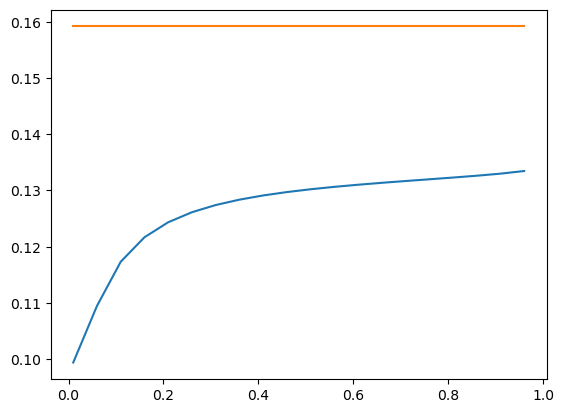

In [2]:
sk2_rad = run_sasktran2(sk.constituent.LambertianSurface(1), 0.5, 0, ss=True, ms_source=sk.MultipleScatterSource.DiscreteOrdinates)
sk1_rad = run_sasktran1_hr(sk1.Lambertian(1), 0.5, 0, ss=True)

plt.plot(COS_VIEWING_ZENITH, sk2_rad.radiance.values[1, :, 0])
plt.plot(COS_VIEWING_ZENITH, sk1_rad.radiance.values[1, :])

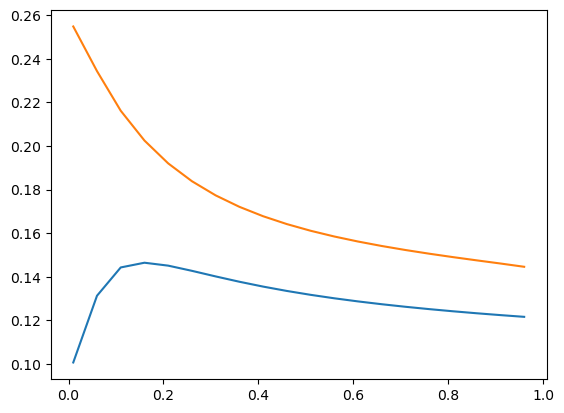

In [3]:
sk2_rad = run_sasktran2(sk.constituent.SnowKokhanovsky(L=3600000, M=5.5e-8), 0.5, 0, ss=True, ms_source=sk.MultipleScatterSource.DiscreteOrdinates)
sk1_rad = run_sasktran1_hr(sk1.Kokhanovsky(L=3600000, M=5.5e-8), 0.5, 0, ss=True)

plt.plot(COS_VIEWING_ZENITH, sk2_rad.radiance.values[1, :, 0])
plt.plot(COS_VIEWING_ZENITH, sk1_rad.radiance.values[1, :])

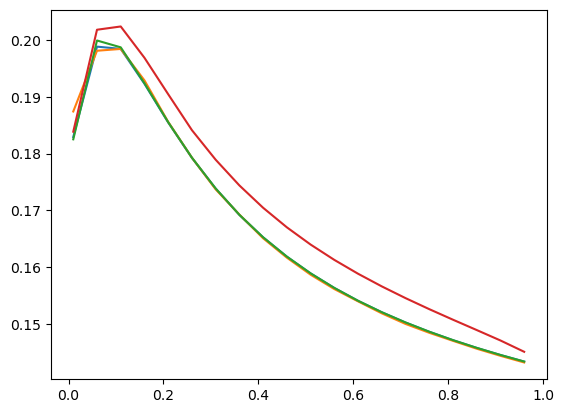

In [8]:
sk2_rad = run_sasktran2(sk.constituent.SnowKokhanovsky(L=3600000, M=5.5e-8), 0.5, 0, ss=False, ms_source=sk.MultipleScatterSource.DiscreteOrdinates, geo=sk.GeometryType.PlaneParallel, ss_source=sk.SingleScatterSource.DiscreteOrdinates)
sk2_rad2 = run_sasktran2(sk.constituent.SnowKokhanovsky(L=3600000, M=5.5e-8), 0.5, 0, ss=False, ms_source=sk.MultipleScatterSource.SuccessiveOrders, geo=sk.GeometryType.PlaneParallel, ss_source=sk.SingleScatterSource.Exact)
sk2_rad3 = run_sasktran2(sk.constituent.SnowKokhanovsky(L=3600000, M=5.5e-8), 0.5, 0, ss=False, ms_source=sk.MultipleScatterSource.DiscreteOrdinates, geo=sk.GeometryType.PlaneParallel, ss_source=sk.SingleScatterSource.Exact)
sk2_rad4 = run_sasktran1_do(sk1.Kokhanovsky(), 0.5, 0, ss=False)


plt.plot(COS_VIEWING_ZENITH, sk2_rad.radiance.values[1, :, 0])
plt.plot(COS_VIEWING_ZENITH, sk2_rad2.radiance.values[1, :])
plt.plot(COS_VIEWING_ZENITH, sk2_rad3.radiance.values[1, :])
plt.plot(COS_VIEWING_ZENITH, sk2_rad4.radiance.values[1, :])

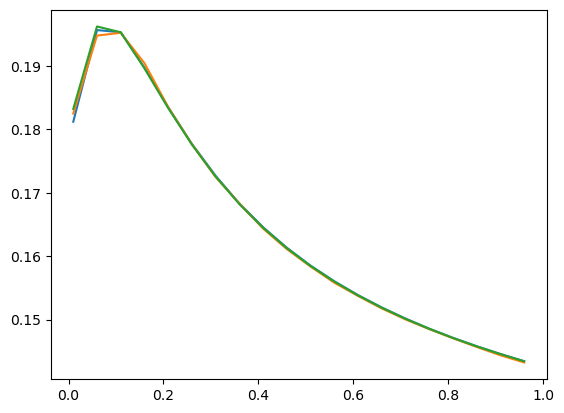

In [9]:
sk2_rad = run_sasktran2(sk.constituent.SnowKokhanovsky(), 0.5, 0.2, ss=False, ms_source=sk.MultipleScatterSource.DiscreteOrdinates, geo=sk.GeometryType.PseudoSpherical, ss_source=sk.SingleScatterSource.DiscreteOrdinates)
sk2_rad2 = run_sasktran2(sk.constituent.SnowKokhanovsky(), 0.5, 0.2, ss=False, ms_source=sk.MultipleScatterSource.SuccessiveOrders, geo=sk.GeometryType.Spherical, ss_source=sk.SingleScatterSource.Exact)
sk2_rad3 = run_sasktran2(sk.constituent.SnowKokhanovsky(), 0.5, 0.2, ss=False, ms_source=sk.MultipleScatterSource.DiscreteOrdinates, geo=sk.GeometryType.Spherical, ss_source=sk.SingleScatterSource.Exact)

plt.plot(COS_VIEWING_ZENITH, sk2_rad.radiance.values[1, :, 0])
plt.plot(COS_VIEWING_ZENITH, sk2_rad2.radiance.values[1, :])
plt.plot(COS_VIEWING_ZENITH, sk2_rad3.radiance.values[1, :])

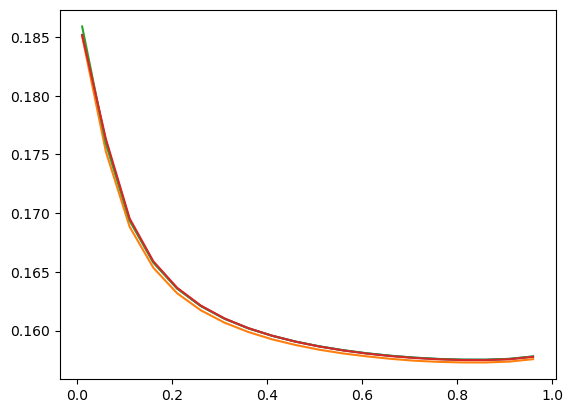

In [11]:
sk2_rad = run_sasktran2(sk.constituent.LambertianSurface(1), 0.5, 0, ss=False, ms_source=sk.MultipleScatterSource.DiscreteOrdinates, geo=sk.GeometryType.PseudoSpherical, ss_source=sk.SingleScatterSource.DiscreteOrdinates)
sk2_rad2 = run_sasktran2(sk.constituent.LambertianSurface(1), 0.5, 0, ss=False, ms_source=sk.MultipleScatterSource.SuccessiveOrders, geo=sk.GeometryType.Spherical, ss_source=sk.SingleScatterSource.Exact)
sk2_rad3 = run_sasktran2(sk.constituent.LambertianSurface(1), 0.5, 0, ss=False, ms_source=sk.MultipleScatterSource.DiscreteOrdinates, geo=sk.GeometryType.Spherical, ss_source=sk.SingleScatterSource.Exact)
sk2_rad4 = run_sasktran1_do(sk1.Lambertian(1), 0.5, 0, ss=False)


plt.plot(COS_VIEWING_ZENITH, sk2_rad.radiance.values[1, :, 0])
plt.plot(COS_VIEWING_ZENITH, sk2_rad2.radiance.values[1, :])
plt.plot(COS_VIEWING_ZENITH, sk2_rad3.radiance.values[1, :])
plt.plot(COS_VIEWING_ZENITH, sk2_rad4.radiance.values[1, :])